# Exploring Evolutionary Track of Individual Stars with Aperture Photometry

#### Author: Nusrath Jahan, Abantika Maytra Oishee, Dibbendu Barua

##### This notebook is just for one star

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns 
import astropy.io.fits as fits

from astropy.io import fits
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.wcs import WCS
from astropy.table import Column

#from photutils.aperture.stats import ApertureStats
from photutils import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats

import warnings
warnings.filterwarnings('ignore')

## Target Star: Info

In [2]:
info = {
    "Type": "STAR",
    "SDSS ObjID": 1237648720693690466, ###
    "ra": 179.646305922715, ###
    "dec": -0.496642091095308 ###
}

# Data for the table
data = {
    "Magnitude": [16.164, 15.774], ###
    "Uncertainty": [0.004, 0.004]  ###
}

df = pd.DataFrame(data, index=["g", "r"])

print(info)
display(df)

{'Type': 'STAR', 'SDSS ObjID': 1237648720693690466, 'ra': 179.646305922715, 'dec': -0.496642091095308}


,Magnitude,Uncertainty
g,16.164,0.004
r,15.774,0.004


## Load Data

In [3]:
image_data_g = fits.open('./frame-g-000756-2-0426.fits')[0].data
image_data_r = fits.open('./frame-r-000756-2-0426.fits')[0].data
fits_file_g = './frame-g-000756-2-0426.fits'

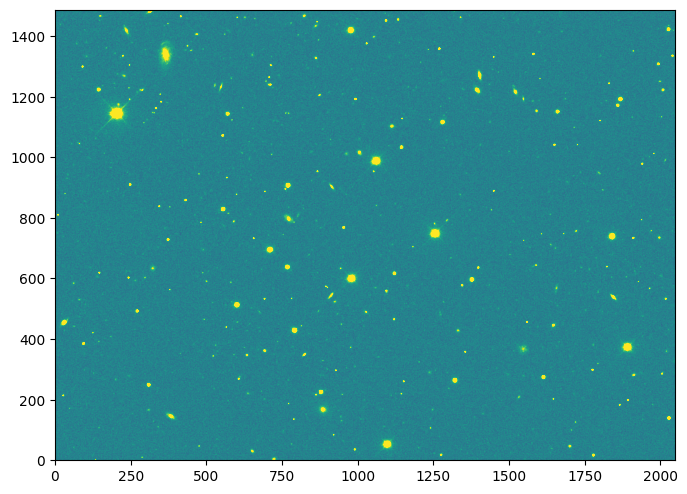

In [4]:
data = fits.open(fits_file_g)[0].data
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(data, origin='lower', vmax=0.1) 

## Covert Coords: Degrees to Pixel

In [5]:
ra = info['ra']
dec =  info['dec']

hdu = fits.open(fits_file_g)[0]  
wcs = WCS(hdu.header)

pixel_coords = wcs.all_world2pix(ra, dec, 1)

pix_x, pix_y = pixel_coords[0]+2, pixel_coords[1]

print(pix_x, pix_y)

1282.7963157693703 1116.6356669986653


## Detect Target Star on Image

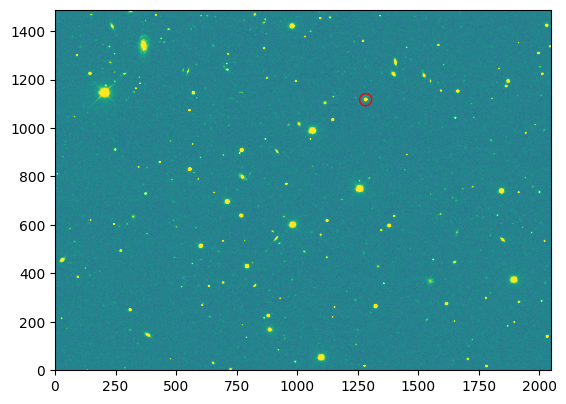

In [6]:
aperture = CircularAperture((pix_x, pix_y), r=25)  
plt.imshow(image_data_g, origin='lower', vmax=0.1)
aperture.plot(color='red', lw=1) 
plt.show()

## Synthetic Star Test

 id xcenter ycenter ...  total_bkg  aperture_sum_bkgsub aperture_sum_bkgsub_err
      pix     pix   ...                                                        
--- ------- ------- ... ----------- ------------------- -----------------------
  1     780     550 ... -0.34606506           1001.9565              0.57531475


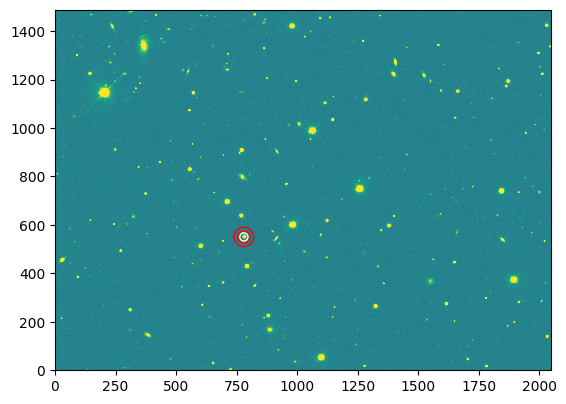

In [ ]:
imblob = np.zeros(np.shape(image_data_g))
x, y = 780, 550
imblob[y, x] = 1000

# Convolve with PSF and add to image
psf = Gaussian2DKernel(2)
imblob = convolve(imblob, psf)
image_data_g += imblob

plt.imshow(image_data_g, origin='lower', vmax=0.1)

# Define positions and aperture parameters
positions_list = [(x, y)]
radius_list = [17]
r_in_list = [25]
r_out_list = [40]

aperture_sum_bkgsub = []

for i in range(len(positions_list)):
    positions = positions_list[i]
    radius = radius_list[i]
    r_in = r_in_list[i]
    r_out = r_out_list[i]

    # Define apertures
    aperture = CircularAperture(positions, radius)
    annulus_aperture = CircularAnnulus(positions, r_in, r_out)

    # Plot apertures
    aperture.plot(color='white', lw=1, label='Photometry aperture')
    annulus_aperture.plot(color='red', lw=1, label='Background annulus')

    # Perform aperture photometry
    phot_table = aperture_photometry(image_data_g, aperture)
    aperture_area = aperture.area_overlap(image_data_g)
    
    # Calculate background stats
    aperstats = ApertureStats(image_data_g, annulus_aperture)
    bkg_mean = aperstats.mean
    total_bkg = bkg_mean * aperture_area
    
    # Calculate background-subtracted flux
    phot_bkgsub = phot_table['aperture_sum'] - total_bkg
    phot_table['total_bkg'] = total_bkg
    phot_table['aperture_sum_bkgsub'] = phot_bkgsub

    # Define errors
    data = np.ones_like(image_data_g)  # Assuming uniform data for simplicity
    error = 0.01 * data  # Example relative error, adjust as needed
    phot_table_with_error = aperture_photometry(image_data_g, aperture, error=error)

    aperture_sum_err = phot_table_with_error['aperture_sum_err']
    bkg_stddev = aperstats.std  # Use std to get the standard deviation
    total_bkg_err = bkg_stddev * np.sqrt(aperture_area)
    
    # Propagate errors to obtain the error of the background-subtracted flux
    aperture_sum_bkgsub_err = np.sqrt(aperture_sum_err**2 + total_bkg_err**2)
    phot_table['aperture_sum_bkgsub_err'] = aperture_sum_bkgsub_err

    # Format and print photometry table
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
        
    print(phot_table)

plt.show()

## Apparent Flux of Vega

In [8]:
L_sun = 3.83e26
L_vega = 47.2 * L_sun
d_vega = 7.68 

# persec to meter
d_vega_m = d_vega * 3.086e16

# Calculate observed/apparent flux of Vega
F_obs_vega = L_vega / (4 * np.pi * (d_vega_m)**2)

print(f"Observed/Apparent flux of Vega: {F_obs_vega:.3e} W/m^2")

Observed/Apparent flux of Vega: 2.561e-08 W/m^2


## Absolute Flux of Vega

In [9]:
# Calculate the absolute flux
F_abs_vega = F_obs_vega * (d_vega / 10)**2

print(f"Absolute flux of Vega: {F_abs_vega:.3e} W/m^2")

Absolute flux of Vega: 1.511e-08 W/m^2


In [10]:
F_obs_vega = 2.6e-08 
F_abs_vega = 1.5e-08 

### Create Function for Aperture Photometry

In [11]:
from photutils import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats
import matplotlib.pyplot as plt
import numpy as np

def do_aper_phot(image_data, positions_list, radius_list, r_in_list, r_out_list):
    plt.imshow(image_data, origin='lower', vmax=0.1)
    aperture_sum_bkgsub_list = []
    aperture_sum_bkgsub_err_list = []

    error_data = 0.01 * image_data
    for i in range(len(positions_list)):
        positions = positions_list[i]
        radius = radius_list[i]
        r_in = r_in_list[i]
        r_out = r_out_list[i]

        # Define apertures
        aperture = CircularAperture(positions, radius)
        annulus_aperture = CircularAnnulus(positions, r_in, r_out)

        # Plot apertures
        aperture.plot(color='white', lw=1, label='Photometry aperture')
        annulus_aperture.plot(color='red', lw=1, label='Background annulus')

        # Perform aperture photometry
        phot_table = aperture_photometry(image_data, aperture)

        # Calculate background stats
        aperstats = ApertureStats(image_data, annulus_aperture)
        bkg_mean = aperstats.mean
        aperture_area = aperture.area_overlap(image_data)

        # Calculate total background
        total_bkg = bkg_mean * aperture_area

        # Calculate background-subtracted flux
        phot_bkgsub = phot_table['aperture_sum'] - total_bkg
        phot_table['total_bkg'] = total_bkg
        phot_table['aperture_sum_bkgsub'] = phot_bkgsub

        # Define errors and perform aperture photometry with errors
        phot_table_with_error = aperture_photometry(image_data, aperture, error=error_data)
        aperture_sum_err = phot_table_with_error['aperture_sum_err']

        # Calculate background error
        bkg_stddev = aperstats.std
        total_bkg_err = bkg_stddev * np.sqrt(aperture_area)

        # Calculate error for background-subtracted flux
        aperture_sum_bkgsub_err = np.sqrt(aperture_sum_err**2 + total_bkg_err**2)
        phot_table['aperture_sum_bkgsub_err'] = aperture_sum_bkgsub_err

        # Append results to lists
        aperture_sum_bkgsub_list.append(phot_bkgsub)
        aperture_sum_bkgsub_err_list.append(aperture_sum_bkgsub_err)

        for col in phot_table.colnames:
            phot_table[col].info.format = '%.8g'

        print(phot_table)

    return aperture_sum_bkgsub_list, aperture_sum_bkgsub_err_list

### Create Function for Measuring Apparent Magnitude from Apparent Flux

In [12]:
import numpy as np

def get_app_mag_star(flux_obs, wavelength_m, flux_obs_err):

    flux_observed_Jy = flux_obs * 3.631e-6  # Jy
    c = 3e8
    frequency_hz = c / wavelength_m

    F_obs_star = (flux_observed_Jy * frequency_hz) / 1e26

    print(f"Observed/Apparent Flux of the star: {F_obs_star:.3e} W/m^2")

    m_app_star = -2.5 * np.log10(F_obs_star / F_obs_vega)
    print(f"Apparent magnitude of the star: {m_app_star:.3f}")

    conversion_factor = (frequency_hz / 1e26) * 3.631e-6

    # Error in observed flux in W/m^2
    F_obs_star_err = flux_obs_err * conversion_factor

    # Error in apparent magnitude
    m_app_star_err = (2.5 / np.log(10)) * (F_obs_star_err / F_obs_star)
    print(f"Error in apparent magnitude of the star: {m_app_star_err:.3f}")

    return F_obs_star, F_obs_star_err, m_app_star, m_app_star_err

# g-band

### Aperture Photometry

In [13]:
positions_list = [(pix_x, pix_y)] 
radius_list = [18] ###
r_in_list = [28] ###
r_out_list = [50] ###

 id  xcenter   ycenter  ... aperture_sum_bkgsub aperture_sum_bkgsub_err
       pix       pix    ...                                            
--- --------- --------- ... ------------------- -----------------------
  1 1282.7963 1116.6357 ...           344.97563              0.83641487


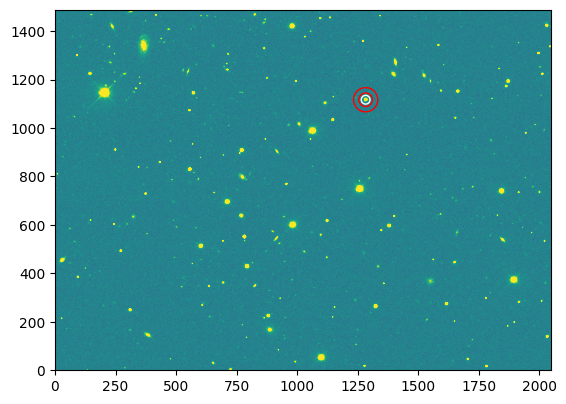

In [14]:
phot_result_g, phot_result_g_err = do_aper_phot(image_data_g, positions_list, radius_list, r_in_list, r_out_list)

In [15]:
flux_obs_g = phot_result_g[0][0]
flux_obs_g_err = phot_result_g_err[0][0]

print(f"Observed/Apparent Flux Value from Aperture Photometry: {flux_obs_g:.5f}")
print(f"Observed/Apparent Flux Error Value from Aperture Photometry: {flux_obs_g_err:.5f}")  


Observed/Apparent Flux Value from Aperture Photometry: 344.97563
Observed/Apparent Flux Error Value from Aperture Photometry: 0.83641


### Apparent Flux to Apparent Magnitude of the Star

In [16]:
wavelength_m_g = 4.77e-7 # g-band wavelength
F_obs_star_g, F_obs_star_g_err, m_app_star_g, m_app_star_g_err = get_app_mag_star(flux_obs_g, wavelength_m_g, flux_obs_g_err)

Observed/Apparent Flux of the star: 7.878e-15 W/m^2
Apparent magnitude of the star: 16.296
Error in apparent magnitude of the star: 0.003


# r-band

### Aperture Photometry

In [17]:
pix_x = pix_x -1 
pix_y = pix_y - 10
positions_list = [(pix_x, pix_y)] 
radius_list = [18] ###
r_in_list = [28] ###
r_out_list = [50] ###

 id  xcenter   ycenter  ... aperture_sum_bkgsub aperture_sum_bkgsub_err
       pix       pix    ...                                            
--- --------- --------- ... ------------------- -----------------------
  1 1281.7963 1106.6357 ...            491.8618               1.2992214


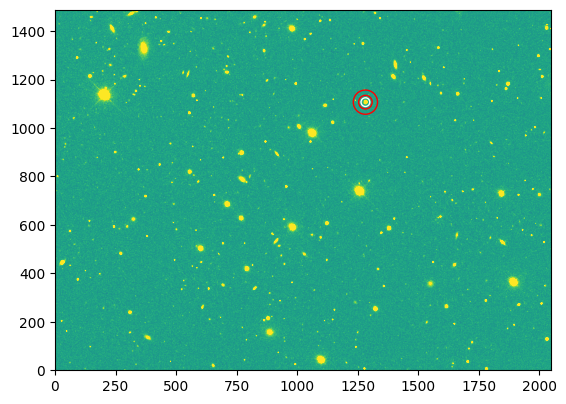

In [18]:
phot_result_r, phot_result_r_err = do_aper_phot(image_data_r, positions_list, radius_list, r_in_list, r_out_list)

In [19]:
flux_obs_r = phot_result_r[0][0]
flux_obs_r_err = phot_result_r_err[0][0]

print(f"Observed/Apparent Flux Value from Aperture Photometry in r-band: {flux_obs_r:.5f}")
print(f"Observed/Apparent Flux Error Value from Aperture Photometry in r-band: {flux_obs_r_err:.5f}")

Observed/Apparent Flux Value from Aperture Photometry in r-band: 491.86180
Observed/Apparent Flux Error Value from Aperture Photometry in r-band: 1.29922


### Apparent Flux to Apparent Magnitude of the Star

In [20]:
wavelength_m_r = 6.231e-7 # r-band wavelength
F_obs_star_r, F_obs_star_r_err, m_app_star_r, m_app_star_r_err = get_app_mag_star(flux_obs_r, wavelength_m_r, flux_obs_r_err)

Observed/Apparent Flux of the star: 8.599e-15 W/m^2
Apparent magnitude of the star: 16.201
Error in apparent magnitude of the star: 0.003


## Apparent Magnitude to Absolute Magnitude of the Star

In [27]:
def calculate_absolute_magnitude_simple(m, F_obs_star, F_abs_vega, delta_m, delta_F_obs_star):
    
    # Calculate absolute magnitude
    M = m + 2.5 * np.log10(F_obs_star / F_abs_vega) + 5
    
    # Calculate error in absolute magnitude
    delta_M = delta_m + (2.5 / np.log(10)) * (delta_F_obs_star / F_obs_star)

    return M, delta_M

M, M_err = calculate_absolute_magnitude_simple(m_app_star_g, F_obs_star_g, F_abs_vega, m_app_star_g_err, F_obs_star_g_err)
print(f"Absolute Magnitude: {M:.5f} ± {M_err:.5f}")

Absolute Magnitude: 5.60023 ± 0.00526


## Color Index Measurement: Transformation of g-r to B-V

In [24]:
g_mag_abs = df.loc["g", "Magnitude"]
r_mag_abs = df.loc["r", "Magnitude"]

g_uncertainty = df.loc["g", "Uncertainty"]
r_uncertainty = df.loc["r", "Uncertainty"]

# Calculate percentage error
error_g = (abs(m_app_star_g - g_mag_abs) / abs(g_mag_abs)) 
error_r = (abs(m_app_star_r - r_mag_abs) / abs(r_mag_abs)) 

print(f"Error (g): {error_g:.5f}")
print(f"Error (r): {error_r:.5f}")

g = m_app_star_g  # g = apparent magnitude in g filter
r = m_app_star_r  # r = apparent magnitude in r filter

# Transformation Equations
B = g + 0.3130 * (g - r) + 0.2271  # sigma = 0.0107
V = g - 0.5784 * (g - r) - 0.0038  # sigma = 0.0054

# Color Index
color_index = B - V
print(f"Color Index of the star: {color_index:.5f}")

# Error Propagation for B and V
B_error = np.sqrt(g_uncertainty**2 + (0.3130 * np.sqrt(g_uncertainty**2 + r_uncertainty**2))**2)
V_error = np.sqrt(g_uncertainty**2 + (-0.5784 * np.sqrt(g_uncertainty**2 + r_uncertainty**2))**2)

# Error of the Color Index (B - V)
color_index_error = np.sqrt(B_error**2 + V_error**2)

print(f"Error in Color Index: {color_index_error:.5f}")
print(f"Color index: {color_index:.5f} ± {color_index_error:.5f}")


Error (g): 0.00819
Error (r): 0.02709
Color Index of the star: 0.31562
Error in Color Index: 0.00677
Color index: 0.31562 ± 0.00677


# Model H-R Diagram with Target Stars

#### This model H-R diagram plots the results of all the stars analyzed in this project, even though the above analysis is done only for one star.

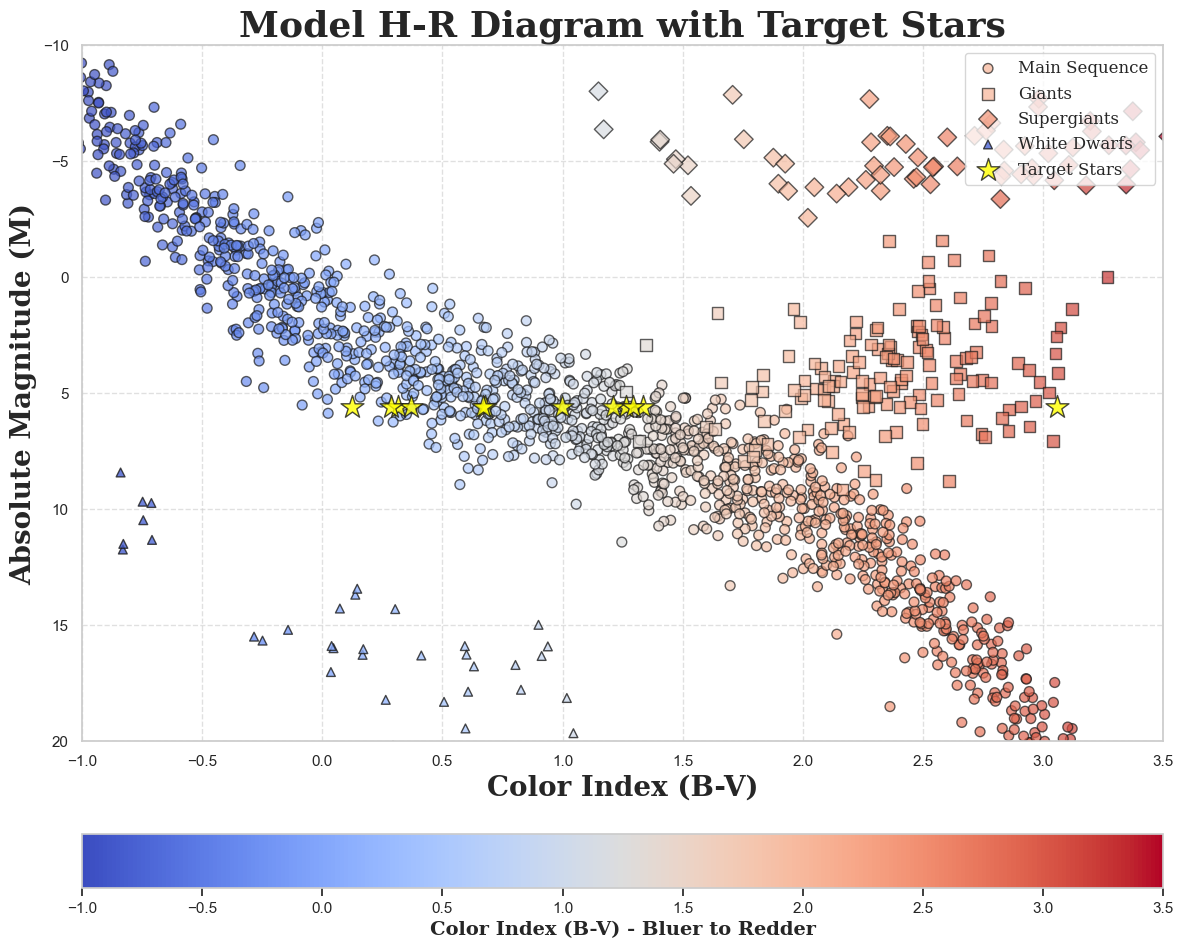

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties  # Import FontProperties

np.random.seed(42)

# Generate data for each stellar type
num_main_sequence = 2000
num_giants = 150
num_supergiants = 75
num_white_dwarfs = 50

# Main Sequence
main_bv = np.random.normal(loc=1.0, scale=2.1, size=num_main_sequence)  
main_mag = np.random.normal(loc=(main_bv - 1) ** 3 + (3 * main_bv) + 3, scale=1.5, size=num_main_sequence)

# Giants
giant_bv = np.random.normal(loc=2.4, scale=0.4, size=num_giants)  
giant_mag = np.random.normal(loc=8.0 - 1.5 * giant_bv, scale=2.0, size=num_giants)

# Supergiants
supergiant_bv = np.random.normal(loc=2.8, scale=0.8, size=num_supergiants)
supergiant_mag = np.random.normal(loc=-5, scale=1.2, size=num_supergiants)

# White Dwarfs
white_dwarf_bv = np.random.normal(loc=-0.25, scale=1.0, size=num_white_dwarfs)
white_dwarf_mag = np.random.normal(loc=15 + 3.5 * white_dwarf_bv, scale=2.0, size=num_white_dwarfs)

# Combine data for plotting
bv = np.concatenate([main_bv, giant_bv, supergiant_bv, white_dwarf_bv])
mag = np.concatenate([main_mag, giant_mag, supergiant_mag, white_dwarf_mag])

# Define target star properties
target_bv = np.array([1.33375, 0.99686, 0.31562, 0.37032, 0.12394, 1.26358, 1.20866, 0.67503, 0.28515, 3.05675, 1.29502, 0.66937])
target_mag = np.array([5.58366, 5.59716, 5.60023, 5.58991, 5.58686, 5.60044, 5.58427, 5.59502, 5.58011, 5.59721, 5.57980, 5.59977])

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 10))

cmap = plt.colormaps.get_cmap("coolwarm")
vmin, vmax = -1, 3.5  
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

main_colors = cmap(norm(main_bv))
giant_colors = cmap(norm(giant_bv))
supergiant_colors = cmap(norm(supergiant_bv))
white_dwarf_colors = cmap(norm(white_dwarf_bv))

ax.scatter(main_bv, main_mag, color=main_colors, edgecolors='k', alpha=0.7, s=50, marker='o', label='Main Sequence')
ax.scatter(giant_bv, giant_mag, color=giant_colors, edgecolors='k', alpha=0.7, s=70, marker='s', label='Giants')
ax.scatter(supergiant_bv, supergiant_mag, color=supergiant_colors, edgecolors='k', alpha=0.7, s=90, marker='D', label='Supergiants')
ax.scatter(white_dwarf_bv, white_dwarf_mag, color=white_dwarf_colors, edgecolors='k', alpha=0.8, s=40, marker='^', label='White Dwarfs')

target_colors = cmap(norm(target_bv))
ax.scatter(target_bv, target_mag, color='yellow', edgecolors='k', alpha=0.8, s=300, marker='*', label='Target Stars')

ax.invert_yaxis()
ax.set_xlim(vmin, vmax)
ax.set_ylim(20, -10)

ax.set_xlabel('Color Index (B-V)', fontsize=20, fontweight='bold', fontdict={'family': 'serif'})
ax.set_ylabel('Absolute Magnitude (M)', fontsize=20, fontweight='bold', fontdict={'family': 'serif'})
ax.set_title('Model H-R Diagram with Target Stars', fontsize=26, fontweight='bold', fontdict={'family': 'serif'})

font_properties = FontProperties(family='serif', size=12)
ax.legend(loc='upper right', prop=font_properties)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_facecolor('white')

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.1)
cbar.set_label('Color Index (B-V) - Bluer to Redder', fontsize=14, fontweight='bold', fontdict={'family': 'serif'})

plt.tight_layout()
fname = 'model_HR'
plt.savefig(fname, dpi=300, bbox_inches='tight')
plt.show()